In [1]:
import sys
import os        
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from pathlib import Path
from models.transformer.utils import get_device
from data import preprocess
from torch import nn
import torch
import matplotlib.pyplot as plt
from torchvision.ops import MLP
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import mean_squared_error
from data.data_loader import get_data_loaders
from utils import *
from data.data_loader import  get_validation_dataloader
from config.utils import load_config
import numpy as np

In [117]:
def infer_and_plot_GAN(model,
                   test_loader,
                   seq_len_future,
                   num_features=4,
                   plot_labels=None,
                   pred_cycle_count=0,
                   predict_earliest=True):
    """
    Generates predictions from the model and plots them against actual data.

    Args:
        model: The trained model.
        test_loader: DataLoader for the test set.
        seq_len_future: Number of future steps the model generates.
        num_features: Number of features to predict
        plot_labels: List of labels of names of features , len(plot_labels) = num_features
        pred_cycle_count : number of prediction cycles to plot
        predict_earliest : weather to start counting the windows from the beginning or the end
    """
    device = get_device()  # Ensure all tensors are on the same device
    model.to(device)  # Move model to the correct device
    model.eval()  # Set the model to evaluation mode

    actual_prices = []
    predicted_prices = []
    dates = []
    
    if pred_cycle_count <= 0:
        pred_cycle_count = len(test_loader)
    elif pred_cycle_count > len(test_loader):
        pred_cycle_count = len(test_loader)

    def skip_windows():
        if predict_earliest:
            return idx >= pred_cycle_count
        else:
            return idx < len(test_loader) - pred_cycle_count

    with torch.no_grad():
        for idx , (batch_input, batch_output, _, output_dates) in enumerate(test_loader):
            if predict_earliest and skip_windows(): #predict from the end of the year
                break
            elif not predict_earliest and skip_windows():
                continue

            batch_input = batch_input.to(device)
            batch_output = batch_output.to(device)
            initial_ohlc = batch_input[:, -1:, :]

            # Generate predictions
            predictions = torch.abs(model(batch_input))

            # Collect real and predicted values
            actual_prices.append(batch_output.cpu().numpy())  # Move to CPU for plotting
            predicted_prices.append(predictions.cpu().numpy())  # Move to CPU for plotting
            dates.append(output_dates.cpu().numpy())


    # Convert lists to numpy arrays
    actual_prices = np.concatenate(actual_prices, axis=0)
    predicted_prices = np.concatenate(predicted_prices, axis=0)
    dates = np.concatenate(dates, axis=0)
    
    actual_prices = actual_prices.reshape(-1, seq_len_future, num_features)
    predicted_prices = predicted_prices.reshape(-1, seq_len_future, num_features)
    dates = convertINT64ToDateTimeObj(dates.reshape(-1))
    
    # Plot OHLC predictions
    if plot_labels is None:
        plot_labels = ['Price', 'Open', 'High', 'Low']
    for i in range(num_features):
        # plt.figure(figsize=(10, 6))
        fig, ax1 = plt.subplots()
        ax1.plot(
             dates,actual_prices[:, :, i].flatten(), label=f"Actual {plot_labels[i]}", color='blue', linewidth = 1
        )
        ax1.set_ylabel(f"Actual {plot_labels[i]}", color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_xlabel("Time Steps")

        ax2 = ax1.twinx()
        ax2.plot(
            dates,predicted_prices[:, :, i].flatten(), label=f"Predicted {plot_labels[i]}", linewidth = 3,
            color='orange', linestyle='dotted'
        )
        ax2.set_ylabel(f"Predicted {plot_labels[i]}", color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')

        plt.title(f"{plot_labels[i]} : Actual vs Predicted")
        fig.tight_layout()  # Adjust layout to avoid overlap
        plt.show()

def test_model_plot_window(configuration_file,
                           weights_file,
                           test_data_file,
                           pred_cycle_count=0,
                           predict_earliest=True):
    """
    @param configuration_file: config file name , under directory config
    @param weights_file: Weights file name , under directory weights/configuration_file
    @param test_data_file: processed test data file name , under directory data/processed
    """
    weights_path = f"../weights/{configuration_file}/{weights_file}"
    config_path = f"../config/{configuration_file}.json"
    # Load the model
    model = load_trained_model(weights_path, config_path)
    print("Model loaded successfully.")
    # test_dataloader, _ = get_data_loaders(f"../data/processed/{test_data_file}",
    #                                       batch_size=1, config_file_path=config_path)
    loader = get_validation_dataloader(f"../data/processed/{test_data_file}",
                                          batch_size=1, config_file_path=config_path)
    infer_and_plot(model,
                   loader,
                   load_config(config_path)['seq_len_future'],
                   pred_cycle_count = pred_cycle_count,
                   predict_earliest = predict_earliest)


In [95]:
def load_trained_model_GAN(weights_path, config_file_path):

    config = load_config(config_file_path)

    model = Generator(
        feature_dim=config["feature_dim"],
        embed_dim=config["embed_dim"],
        seq_len_past=config["seq_len_past"],
        seq_len_future=config["seq_len_future"],
        num_heads=config["num_heads"],
        num_layers=config["num_layers"],
        ff_dim=config["ff_dim"],
        dropout=config["dropout"]
    )

    # Load weights
    model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu'), weights_only=True), strict=False)

    # Set model to evaluation mode
    model.eval()

    return model

In [4]:
def test_model_plot_window_GAN(configuration_file,
                           weights_file,
                           test_data_file,
                           pred_cycle_count=0,
                           predict_earliest=True):
    """
    @param configuration_file: config file name , under directory config
    @param weights_file: Weights file name , under directory weights/configuration_file
    @param test_data_file: processed test data file name , under directory data/processed
    """
    weights_path = f"../weights/{configuration_file}/{weights_file}"
    config_path = f"../config/{configuration_file}.json"
    # Load the model
    model = load_trained_model_GAN(weights_path, config_path)
    print("Model loaded successfully.")
    # test_dataloader, _ = get_data_loaders(f"../data/processed/{test_data_file}",
    #                                       batch_size=1, config_file_path=config_path)
    loader = get_validation_dataloader(f"../data/processed/{test_data_file}",
                                          batch_size=1, config_file_path=config_path)
    infer_and_plot_GAN(model,
                   loader,
                   load_config(config_path)['seq_len_future'],
                #    load_config(config_path)['embed_dim'],
                  #  30,
                   pred_cycle_count = pred_cycle_count,
                   predict_earliest = predict_earliest)

In [5]:
data_folder = 'data'
raw_data_folder = 'raw'
processed_data_folder = 'processed'
scalers_folder = 'scalers'

Path(f"../{data_folder}/{raw_data_folder}").mkdir(parents=True, exist_ok=True)
Path(f"../{data_folder}/{processed_data_folder}").mkdir(parents=True, exist_ok=True)
Path(f"../{data_folder}/{scalers_folder}").mkdir(parents=True, exist_ok=True)

files = [
    "EGX 30 Historical Data_010308_280218"
]

    # Call the main function with the paths, create folders if missing
for file in files:
    preprocess.main(f"../{data_folder}/{raw_data_folder}/{file}.csv", f"../{data_folder}/{processed_data_folder}/{file}_processed.csv", f"../{data_folder}/{scalers_folder}/{file}_scaler.pkl")

Processed data saved to ../data/processed/EGX 30 Historical Data_010308_280218_processed.csv


In [6]:
class StockPricePredictorGAN(nn.Module):
    def __init__(self, feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout=0.1):
        super().__init__()

        self.seq_len_future = seq_len_future
        #Transformer
        self.generator = Generator(feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout)
        self.discriminator = Discriminator(feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout)

        #output Projection Layer
        self.output_layer = nn.Linear(embed_dim, 4)

    def forward(self, encoder_input, decoder_input):
        #encoder Processing
        return self.discriminator(encoder_input)

    def generate(self, encoder_input, initial_prices, future_steps):
        """
        Generate future OHLC prices autoregressively.

        Args:
        - encoder_input: (batch_size, seq_len_past, feature_dim) Past price history.
        - initial_prices: (batch_size, 1, 4) Initial OHLC prices to start predictions.
        - future_steps: int, Number of future steps to predict.

        Returns:
        - Tensor of shape (batch_size, future_steps, 4) with predicted OHLC values.
        """
        return self.generator(encoder_input)
        

In [7]:
def train_GAN_model(generator, discriminator, dataloader, num_epochs=10, lr=0.001, save_path="model.pth"):
    # Set model to training mode
    generator.train()
    discriminator.train()

    # Define loss function and optimizer
    # criterion = nn.MSELoss()
    criterion = nn.BCELoss()
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize best_loss to a large value
    batch_size = 64

    for epoch in range(num_epochs):
        epoch_loss = 0

        for batch_input, batch_output, _, _ in dataloader:
            for n, real_samples in enumerate(batch_input):
                # Data for training the discriminator
                # print(generated_samples[0])
                real_samples_labels = torch.ones((len(real_samples), 1))
                latent_space_samples = torch.randn((len(real_samples), 4))
                generated_samples = generator(latent_space_samples)
                generated_samples_labels = torch.zeros((len(real_samples), 1))
                # print(batch_input[1])
                all_samples = torch.cat((real_samples, generated_samples))
                all_samples_labels = torch.cat(
                    (real_samples_labels, generated_samples_labels)
                )

                # Training the discriminator
                discriminator.zero_grad()
                output_discriminator = discriminator(all_samples)
                loss_discriminator = criterion(output_discriminator, all_samples_labels)
                loss_discriminator.backward()
                optimizer_discriminator.step()

                # Data for training the generator
                latent_space_samples = torch.randn((len(real_samples), 4))

                # Training the generator
                generator.zero_grad()
                generated_samples = generator(latent_space_samples)
                output_discriminator_generated = discriminator(generated_samples)
                loss_generator = criterion(output_discriminator_generated, real_samples_labels)
                loss_generator.backward()
                optimizer_generator.step()
                epoch_loss = loss_generator.item() + loss_discriminator.item()

        avg_epoch_loss = epoch_loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D.: {loss_discriminator}")
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss G.: {loss_generator}")

        # Save the model if it achieves the best loss
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save(generator.state_dict(), os.path.join(save_path, f"GAN_model_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_epoch_{epoch+1}_bce_{best_loss}.pth"))
            print(f"Model saved at epoch {epoch+1}")
        if epoch % 10 == 0:
            torch.save(generator.state_dict(), os.path.join(save_path, f"GAN_model_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_epoch_{epoch+1}_bce_{avg_epoch_loss}.pth"))


In [8]:
class Discriminator(nn.Module):
    def __init__(self, feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout=0.1):
        super().__init__()
        self.model = MLP(feature_dim, (embed_dim, 1), activation_layer=nn.Sigmoid, dropout=0.1)

    def forward(self, x):
        output = torch.sigmoid(self.model(x))
        return output

In [9]:
class Generator(nn.Module):
    def __init__(self, feature_dim, embed_dim, seq_len_past, seq_len_future, num_heads, num_layers, ff_dim, dropout=0.1):
        super().__init__()
        self.model = nn.Sequential(
            nn.LSTM(input_size=feature_dim, hidden_size=embed_dim, num_layers=num_layers, dropout=dropout),
            )

    def forward(self, x):
        output = self.model(x)
        return output[0]
    
    def generate(self, encoder_input=None,
                initial_prices=None,
                future_steps=None):
        return self.forward(encoder_input)

In [10]:
args = lambda: None
args.model_config_id = "config_4"
args.learning_rate = 0.00025
args.num_epochs = 30


# Initialize the model with hyperparameters
config_id = args.model_config_id
config_file_path = f"../config/{config_id}.json"

config = load_config(config_file_path, verbose=True)
weights_path = f"../weights/{config_id}/"
path = Path(weights_path)
path.mkdir(parents=True, exist_ok=True)
model = StockPricePredictorGAN(
    feature_dim=config["feature_dim"],
    embed_dim=config["embed_dim"],
    seq_len_past=config["feature_dim"],
    seq_len_future=config["feature_dim"],
    num_heads=config["num_heads"],
    num_layers=config["num_layers"],
    ff_dim=config["ff_dim"],
    dropout=config["dropout"]
# ).to(get_device())
)

# Initialize DataLoader
train_dataloader, test_data_loader= get_data_loaders(
            processed_data_path= '../data/processed/EGX 30 Historical Data_010308_280218_processed.csv',
            batch_size=64,
            config_file_path=config_file_path
    )

learning_rate = args.learning_rate
discriminator = Discriminator(feature_dim=config["feature_dim"],
    embed_dim=config["embed_dim"],
    seq_len_past=config["seq_len_past"],
    seq_len_future=config["seq_len_future"],
    num_heads=config["num_heads"],
    num_layers=config["num_layers"],
    ff_dim=config["ff_dim"],
    dropout=config["dropout"])
generator = Generator(feature_dim=config["feature_dim"],
    embed_dim=config["feature_dim"],
    seq_len_past=config["seq_len_past"],
    seq_len_future=config["seq_len_future"],
    num_heads=config["num_heads"],
    num_layers=config["num_layers"],
    ff_dim=config["ff_dim"],
    dropout=config["dropout"])
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate)
train_loss = train_GAN_model(generator, discriminator, train_dataloader, num_epochs=args.num_epochs, lr=args.learning_rate, save_path=weights_path)

# After training, you can evaluate the model
# mse = train_stock_predictor.evaluate_model(model, test_data_loader)

Model parameters: {'feature_dim': 4, 'embed_dim': 4, 'seq_len_past': 5, 'seq_len_future': 5, 'num_heads': 1, 'num_layers': 2, 'ff_dim': 4, 'dropout': 0.1}
Epoch [1/30], Loss: 1.3910
Epoch [1/30] Loss D.: 0.6889535188674927
Epoch [1/30] Loss G.: 0.7020840644836426
Model saved at epoch 1
Epoch [2/30], Loss: 1.3716
Epoch [2/30] Loss D.: 0.7050447463989258
Epoch [2/30] Loss G.: 0.6665456891059875
Model saved at epoch 2
Epoch [3/30], Loss: 1.3790
Epoch [3/30] Loss D.: 0.712870717048645
Epoch [3/30] Loss G.: 0.6661261320114136
Epoch [4/30], Loss: 1.3990
Epoch [4/30] Loss D.: 0.6949845552444458
Epoch [4/30] Loss G.: 0.7040550708770752
Epoch [5/30], Loss: 1.3548
Epoch [5/30] Loss D.: 0.6746600866317749
Epoch [5/30] Loss G.: 0.6801624894142151
Model saved at epoch 5
Epoch [6/30], Loss: 1.3995
Epoch [6/30] Loss D.: 0.6934977173805237
Epoch [6/30] Loss G.: 0.706025242805481
Epoch [7/30], Loss: 1.3973
Epoch [7/30] Loss D.: 0.6745673418045044
Epoch [7/30] Loss G.: 0.7227068543434143
Epoch [8/30], L

In [15]:
def evaluate_model_GAN(generator, test_dataloader):
    generator.to(get_device())
    generator.eval()  # Set model to evaluation mode
    all_true = []
    all_pred = []

    with torch.no_grad():
        for batch_input, batch_output, _, _ in test_dataloader:
            batch_input = batch_input.to(get_device())
            batch_output = batch_output.to(get_device())
            predictions = generator(batch_input)

            all_true.append(batch_output.cpu().numpy())
            all_pred.append(predictions.cpu().numpy())

    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)

    all_true_flat = all_true.reshape(-1, all_true.shape[-1])
    all_pred_flat = all_pred.reshape(-1, all_pred.shape[-1])
    mse = mean_squared_error(all_true_flat, all_pred_flat)
    print(f"Test MSE: {mse:.4f}")

    return mse

In [17]:
mse = evaluate_model_GAN(generator, test_data_loader)

Test MSE: 0.3316


Model loaded successfully.


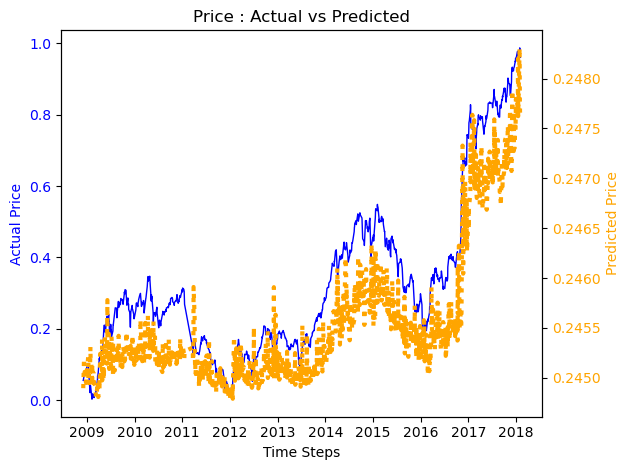

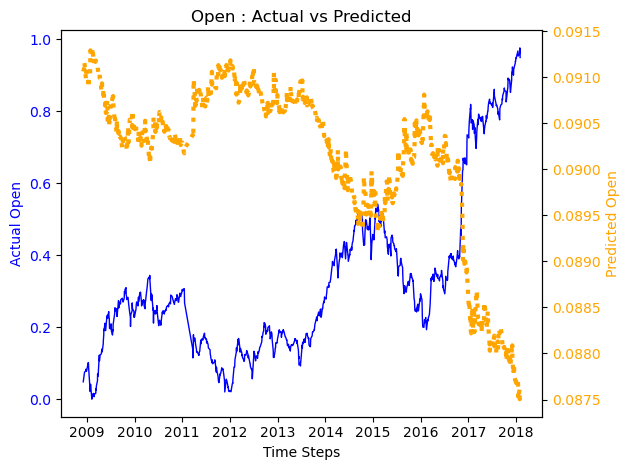

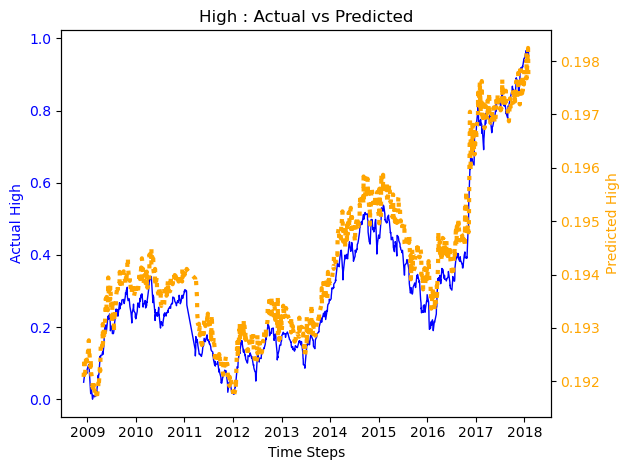

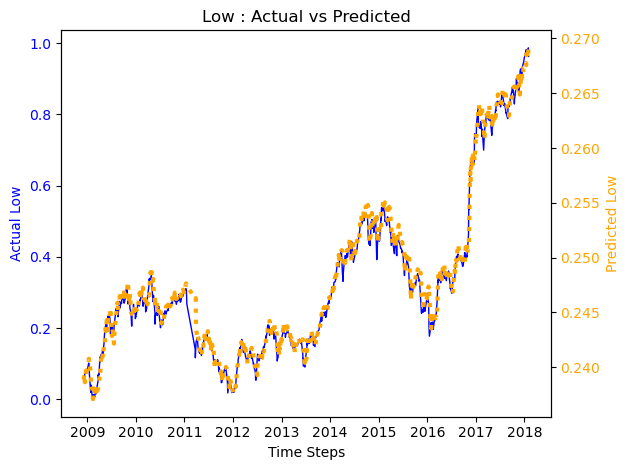

In [119]:

test_model_plot_window_GAN(
    "config_4",
    "GAN_model_2024-12-28_19-20-18_epoch_5_bce_1.35482257604599.pth",
    "EGX 30 Historical Data_010308_280218_processed.csv",
    pred_cycle_count = 0,
    predict_earliest = False)